**This notebook focuses on the effectiveness of PixelDefend against adversarial attacks on the MNIST and MARVEL datasets.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

from keras_radam import RAdam

import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import PixelDefend
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier, PyTorchClassifier
from art.utils import load_mnist

### Load PixelCNN

### **Modification: Disabling eager execution to enable adversarial crafting**

In [ ]:
tf.compat.v1.disable_eager_execution()

### **Load MARVEL dataset**

In [ ]:
x_train = []
y_train = []
x_test_cln = []
y_test_cln = [] 
min_pixel_value = 0
max_pixel_value = 1

def marvel_class(filename):
    switcher={
        'HeavyLoadCarrier': [1,0,0,0,0,0,0,0,0],
        'CombatVessel': [0,1,0,0,0,0,0,0,0],
        'ContainerShip': [0,0,1,0,0,0,0,0,0],
        'PassengersShip': [0,0,0,1,0,0,0,0,0],
        'Ro-roCargo': [0,0,0,0,1,0,0,0,0],
        'Tanker': [0,0,0,0,0,1,0,0,0],
        'Tug': [0,0,0,0,0,0,1,0,0],
        'SupplyVessel': [0,0,0,0,0,0,0,1,0],
        'Yacht': [0,0,0,0,0,0,0,0,1]
    }
    return switcher.get(filename)

def load_training_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/train_9/"+filename
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:      
            img = cv2.resize(img, (320,240))
            x_train_cln.append(img/255)
            y_train_cln.append(marvel_class(filename))
            i = i+1
        if i == 100:
            break
    return x_train_cln, y_train_cln

def load_test_data(filename):
    url = "/home/cyber/Desktop/Adrian/marvel_data/test_9/"+filename
    i = 0
    for imgname in os.listdir(url):
        img = cv2.imread(os.path.join(url,imgname))
        if img is not None:
            img = cv2.resize(img, (320,240))
            x_test_cln.append(img/255)
            y_test_cln.append(marvel_class(filename))
            i = i + 1
        if i == 100:
            break
    return x_test_cln, y_test_cln

# for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/train_9"):
#     load_training_data(filename)
#     print(filename)

for filename in os.listdir("/home/cyber/Desktop/Adrian/marvel_data/test_9"):
    load_test_data(filename)
    print(filename)
    
#load_training_data("/home/cyber/Desktop/Adrian/marvel_data/test_9/CombatVessel")


*Modification: Convert MARVEL x_test/x_train from uint8 into float32, to enable classification*

In [ ]:
x_test_cln = np.array(x_test_cln, dtype=np.float32)

### **Load MNIST dataset**

In [12]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_mnist()
# x_train_cln = x_train_cln.astype(np.float32)
# x_test_cln, y_test_cln = x_test_cln[:1000], y_test_cln[:100]

### **Load / Create classifier model**

*MNIST pre-trained model*

In [ ]:
model = load_model("/home/cyber/mnist_trained_model.h5")

*MARVEL pre-trained model*

In [ ]:
model_path = "/home/cyber/Desktop/Adrian/Xception-10-0.74.hdf5"
model = load_model(model_path, custom_objects={'RAdam': RAdam}, compile=False)

*Optional step: Train and save a model for future use*

In [ ]:
# model.fit(x_train_cln, y_train_cln, batch_size=64, epochs=10, verbose=True)

In [ ]:
# model.save("/home/cyber/dataset_trained_model.h5")

*Create ART classifier*

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on clean test examples

In [ ]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on benign test examples: {}%".format(accuracy_cln * 100))

Step 2: Split clean test examples into true and false positives

In [ ]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of benign true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of benign false positives: {:}'.format(len(x_test_cln_fp)))

Step 3: Craft adversarial examples

*Jacobian-based Saliency Map Attack (JSMA)*

In [ ]:
# adv_crafter = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=0.3, verbose=True)
# x_test_JSMA_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_JSMA_MARVEL

*Basic Iterative Method (BMI)*

In [ ]:
# adv_crafter = BasicIterativeMethod(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_BIM_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_BIM_MARVEL

*Projected Gradient Descent (PGD)*

In [ ]:
# adv_crafter = ProjectedGradientDescent(classifier, eps=0.1, eps_step=0.01, max_iter=30)
# x_test_PGD_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_PGD_MARVEL

*NewtonFool*

In [ ]:
# adv_crafter =  NewtonFool(classifier=classifier, eta=0.005, max_iter=25, verbose=True)
# x_test_Newton_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Newton_MARVEL

*DeepFool*

In [ ]:
# adv_crafter = DeepFool(classifier=classifier, epsilon=1e-06/255, max_iter=50)
# x_test_Deep_MARVEL = adv_crafter.generate(x_test_cln)
# %store x_test_Deep_MARVEL

*Adversarial Examples*

In [5]:
%store -r x_test_JSMA_MNIST
x_test_adv = x_test_JSMA_MNIST

Step 4: Evaluate the classifier on the adversarial test set

In [ ]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Step 5: Split the adversarial test examples into true and false positives

In [ ]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Optional step: Plot benign samples and their adversarial counterparts

In [ ]:
#plot images
plt.figure(figsize=(10, 10))
num = 3

for i in range(num):
    ax = plt.subplot(4, num, i + 1)
    plt.imshow(x_test_cln[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, num, i + num + 1)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **PixelDefend**

Step 1: Transform input

In [6]:
defence = PixelDefend(eps=5, pixel_cnn=pixelcnn, verbose=True)

In [7]:
# x_test_adv = x_test_adv.astype(np.float32)
x_test_adv_pd = defence(x_test_adv*255)[0] / 255

PixelDefend:   0%|          | 0/10000 [00:00<?, ?it/s]

<ipython-input-8-87b552416341>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(4, num/2, i + 1)
<ipython-input-8-87b552416341>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(4, num/2, i + num + 1)


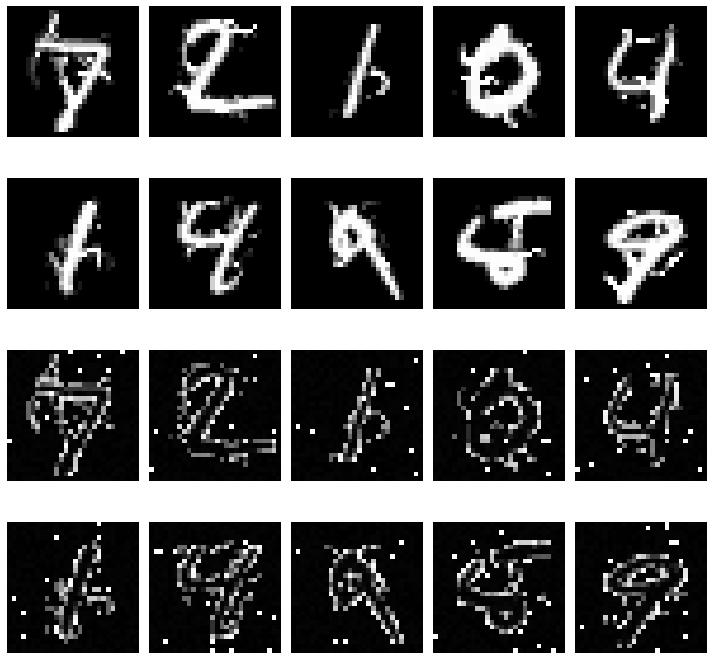

In [8]:
#plot images
plt.figure(figsize=(10, 10))
num = 10

for i in range(num):
    ax = plt.subplot(4, num/2, i + 1)
    plt.imshow(x_test_adv[i], cmap='gray')
    plt.axis("off")
    
    ax = plt.subplot(4, num/2, i + num + 1)
    plt.imshow(x_test_adv_pd[i], cmap='gray')
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [ ]:
x_test_cln_pd = defence(x_test_cln*255)[0] / 255
x_test_cln_tp_pd = defence(x_test_cln_tp * 255)[0] / 255
x_test_cln_fp_pd = defence(x_test_cln_fp * 255)[0] / 255

In [ ]:
x_test_adv_pd = defence(x_test_adv*255)[0] / 255
x_test_adv_tp_pd = defence(x_test_adv_tp * 255)[0] / 255
x_test_adv_fp_pd = defence(x_test_adv_fp * 255)[0] / 255

Step 2: Evaluate the classifier on all 4 sets of data after PixelDefend

In [ ]:
predictions_cln_pd = classifier.predict(x_test_cln_pd)
accuracy_cln_pd = np.sum(np.argmax(predictions_cln_pd, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Effect of PixelDefend on entire clean test set: {:.2f}%".format((accuracy_cln_pd - accuracy_cln) * 100))
 
predictions_cln_tp_pd = classifier.predict(x_test_cln_tp_pd)
accuracy_cln_tp_pd = np.sum(np.argmax(predictions_cln_tp_pd, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_tp_pd * 100))
print("\nAccuracy drop on true positive clean test examples after PixelDefend: {:.2f}%".format((1 - accuracy_cln_tp_pd) * 100))

predictions_cln_fp_pd = classifier.predict(x_test_cln_fp_pd)
accuracy_cln_fp_pd = np.sum(np.argmax(predictions_cln_fp_pd, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive clean test examples after PixelDefend: {:.2f}%".format(accuracy_cln_fp_pd * 100))

predictions_adv_pd = classifier.predict(x_test_adv_pd)
accuracy_adv_pd = np.sum(np.argmax(predictions_adv_pd, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("\nEffect of PixelDefend on entire adversarial test set: {:.2f}%".format((accuracy_adv_pd-accuracy_adv) * 100))

predictions_adv_tp_pd = classifier.predict(x_test_adv_tp_pd)
accuracy_adv_tp_pd = np.sum(np.argmax(predictions_adv_tp_pd, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_tp_pd * 100))
print("\nAccuracy drop on true positive adversarial test examples after PixelDefend: {:.2f}%".format((1 - accuracy_adv_tp_pd) * 100))

predictions_adv_fp_pd = classifier.predict(x_test_adv_fp_pd)
accuracy_adv_fp_pd = np.sum(np.argmax(predictions_adv_fp_pd, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after PixelDefend: {:.2f}%".format(accuracy_adv_fp_pd * 100))

Optional step: Plot all data pre- and post-transformation

In [ ]:
#plot images
predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

plt.figure(figsize=(10, 10))

#Plot clean true positives
ax = plt.subplot(4, 2, 2*0+1)
plt.imshow(x_test_cln_tp[0], cmap='gray')
ax.set_title('Clean TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*0+2)
plt.imshow(x_test_cln_tp_pd[0], cmap='gray')
ax.set_title('Clean TP after PixelDefend: {:}'.format(np.argmax(predictions_cln_tp_pd,axis=1)[0]))
plt.axis("off")

#Plot clean false positives
ax = plt.subplot(4, 2, 2*1+1)
plt.imshow(x_test_cln_fp[0], cmap='gray')
ax.set_title('Clean FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]), fontsize=20)
plt.axis("off")

ax = plt.subplot(4, 2, 2*1+2)
plt.imshow(x_test_cln_fp_pd[0], cmap='gray')
ax.set_title('Clean FP after PixelDefend: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp_pd,axis=1)[0], np.argmax(y_test_cln_fp,axis=1)[0]))
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(4, 2, 2*2+1)
plt.imshow(x_test_adv_tp[0], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*2+2)
plt.imshow(x_test_adv_tp_pd[0], cmap='gray')
ax.set_title('Adversarial TP after PixelDefend: {:}'.format(np.argmax(predictions_adv_tp_pd,axis=1)[0]))
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(4, 2, 2*3+1)
plt.imshow(x_test_adv_fp[0], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(4, 2, 2*3+2)
plt.imshow(x_test_adv_fp_pd[0], cmap='gray')
ax.set_title('Adversarial FP after PixelDefend: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp_pd,axis=1)[0], np.argmax(y_test_adv_fp,axis=1)[0]))
plt.axis("off")
    
plt.tight_layout()
plt.show()

## Others

Optional step: Compare the performance of TotalVarMin against the adversary over a range of eps values

In [ ]:
# eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# accuracy_original = []
# accuracy_robust = []

# adv_crafter = FastGradientMethod(classifier)
# adv_crafter_robust = FastGradientMethod(robust_classifier)

# for eps in eps_range:
#     adv_crafter.set_params(**{'eps': eps})
#     adv_crafter_robust.set_params(**{'eps': eps})
#     x_test_adv = adv_crafter.generate(x_test[:100])
#     x_test_adv_robust = adv_crafter_robust.generate(x_test[:100])
    
#     predictions_original = np.argmax(classifier.predict(x_test_adv), axis=1)
#     accuracy_original += [np.sum(predictions_original == np.argmax(y_test[:100], axis=1))]
    
#     predictions_robust = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
#     accuracy_robust += [np.sum(predictions_robust == np.argmax(y_test[:100], axis=1))]

# eps_range = eps_range

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(np.array(eps_range), np.array(accuracy_original), 'b--', label='Original classifier')
# ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')

# legend = ax.legend(loc='upper right', shadow=True, fontsize='large')
# #legend.get_frame().set_facecolor('#00FFCC')

# plt.xlabel('Attack strength (eps)')
# plt.ylabel('Accuracy (%)')
# plt.show()

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, utils, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

from art.estimators.classification.pytorch import PyTorchClassifier
from art.defences.preprocessor import PixelDefend

def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_or(
        row_grid < starting_point[0],
        np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()

        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import unittest

import numpy as np
import torch.nn as nn
import torch.optim as optim

from art.estimators.classification.pytorch import PyTorchClassifier
from art.defences.preprocessor import PixelDefend
from art.utils import load_mnist

from tests.utils import master_seed

class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        self.fc = nn.Linear(28*28, 28*28*256)

    def forward(self, x):
        x = x.view(-1, 28*28)
        logit_output = self.fc(x)
        logit_output = logit_output.view(-1, 28, 28, 1, 256)

        return logit_output

In [4]:
# Define the network
model = PixelCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
pixelcnn = PyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(28, 28, 1), nb_classes=10, clip_values=(0, 1)
)

In [18]:
x_train_cln = x_train_cln.astype(np.float32)

In [19]:
pixelcnn.fit(x_train_cln, y_train_cln, 64, 10)

ValueError: Expected target size (64, 28, 1, 256), got torch.Size([64])

In [10]:
import torch.nn.functional as F

mnist_data = datasets.MNIST(root=r'/home/cyber/Desktop/Adrian', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
N_EPOCHS = 3
BATCH_SIZE = 64
LR = 0.01

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

train_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images)
        optimizer.zero_grad()
        loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data[0]))



ValueError: Expected target size (64, 28, 1, 256), got torch.Size([64, 1, 28, 28])

### Attempt 2

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, utils, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from MaskedCNN import MaskedCNN
import torch.nn as nn

class PixelCNN(nn.Module):
	"""
	Network of PixelCNN as described in A Oord et. al. 
	"""
	def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.Conv2d_1 = MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_1 = nn.BatchNorm2d(channels)
		self.ReLU_1= nn.ReLU(True)

		self.Conv2d_2 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_2 = nn.BatchNorm2d(channels)
		self.ReLU_2= nn.ReLU(True)

		self.Conv2d_3 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_3 = nn.BatchNorm2d(channels)
		self.ReLU_3= nn.ReLU(True)

		self.Conv2d_4 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_4 = nn.BatchNorm2d(channels)
		self.ReLU_4= nn.ReLU(True)

		self.Conv2d_5 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_5 = nn.BatchNorm2d(channels)
		self.ReLU_5= nn.ReLU(True)

		self.Conv2d_6 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_6 = nn.BatchNorm2d(channels)
		self.ReLU_6= nn.ReLU(True)

		self.Conv2d_7 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_7 = nn.BatchNorm2d(channels)
		self.ReLU_7= nn.ReLU(True)

		self.Conv2d_8 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
		self.BatchNorm2d_8 = nn.BatchNorm2d(channels)
		self.ReLU_8= nn.ReLU(True)

		self.out = nn.Conv2d(channels, 256, 1)

	def forward(self, x):
# 		x = torch.mean(x,dim=1,keepdim=True)
        
		x = self.Conv2d_1(x)
		x = self.BatchNorm2d_1(x)
		x = self.ReLU_1(x)

		x = self.Conv2d_2(x)
		x = self.BatchNorm2d_2(x)
		x = self.ReLU_2(x)

		x = self.Conv2d_3(x)
		x = self.BatchNorm2d_3(x)
		x = self.ReLU_3(x)

		x = self.Conv2d_4(x)
		x = self.BatchNorm2d_4(x)
		x = self.ReLU_4(x)

		x = self.Conv2d_5(x)
		x = self.BatchNorm2d_5(x)
		x = self.ReLU_5(x)

		x = self.Conv2d_6(x)
		x = self.BatchNorm2d_6(x)
		x = self.ReLU_6(x)

		x = self.Conv2d_7(x)
		x = self.BatchNorm2d_7(x)
		x = self.ReLU_7(x)

		x = self.Conv2d_8(x)
		x = self.BatchNorm2d_8(x)
		x = self.ReLU_8(x)

		return self.out(x)

In [ ]:
model = PixelCNN()
model.load_state_dict(torch.load("/home/cyber/miniconda3/envs/tf-gpu/PixelCNN-Pytorch-master/Models/Model_Checkpoint_Last.pt"))
model.eval()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
pixelcnn = PyTorchClassifier(model=model, loss=loss_fn, optimizer=optimizer, input_shape=(28, 28, 1), nb_classes=10, clip_values=(0, 1))

Attempt 3

In [ ]:
from torch import nn


class MaskedConv2d(nn.Conv2d):
    """
    Implementation by jzbontar/pixelcnn-pytorch
    
    mask_type: must be 'A' or 'B' (see [1])
    """
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in ['A', 'B']
        self.register_buffer('mask', self.weight.data.clone())
        h = self.weight.size()[2]
        w = self.weight.size()[3]
        self.mask.fill_(1)
        self.mask[:, :, h // 2, w // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, h // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
    

class GatedMaskedConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super(GatedMaskedConv2d, self).__init__()
        self.masked_conv_1 = MaskedConv2d(*args, **kwargs)
        self.masked_conv_2 = MaskedConv2d(*args, **kwargs)
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        """
        x: input
        """
        inp = self.tanh(self.masked_conv_1(x))
        gate = self.sigm(self.masked_conv_2(x))
        return inp*gate

    

class CondGatedMaskedConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super(CondGatedMaskedConv2d, self).__init__()
        self.masked_conv_1 = MaskedConv2d(*args, **kwargs)
        self.masked_conv_2 = MaskedConv2d(*args, **kwargs)
        self.cond_conv_1 = nn.Conv2d(1, args[2], 1)
        self.cond_conv_2 = nn.Conv2d(1, args[2], 1)
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()

    def forward(self, x, h):
        """
        x: input
        h: conditional input (should have the same shape as input)
        """
        inp = self.tanh(self.masked_conv_1(x)
                        + self.cond_conv_1(h))
        gate = self.sigm(self.masked_conv_2(x)
                         + self.cond_conv_2(h))
        return inp * gate

In [ ]:
from torch import nn
import numpy as np


class PixelCNN(nn.Module):
    """
    Conditional PixelCNN using gated convolutional layers
    
    n_channels: channels for each convolutional layer
    n_layers: number of intermediate convolutional layers
    """
    def __init__(self, n_channels=32, n_layers=7):
        super(PixelCNN, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(CondGatedMaskedConv2d('A', 1, n_channels,
                                                 7, 1, 3, bias=False))
        self.layers.append(nn.BatchNorm2d(n_channels))
        
        for i in range(1, n_layers+1):
            self.layers.append(CondGatedMaskedConv2d('B', n_channels,
                                                     n_channels, 7, 1, 3,
                                                     bias=False))
            self.layers.append(nn.BatchNorm2d(n_channels))

        # map to 256 output channels
        self.layers.append(nn.Conv2d(n_channels, 256, 1))
    
    def forward(self, x, h):
        out = x
        for layer in self.layers:
            # only pass conditional input to the CondGatedMaskedConv2d layers
            if isinstance(layer, CondGatedMaskedConv2d):
                out = layer(out, h)
            else:
                out = layer(out)
        return out
                              

class LabelNet(nn.Module):
    """
    Linear layer to map from one-hot-encoded label to 28x28
    """
    def __init__(self, input_shape=10, output_shape=(28,28)):
        super(LabelNet, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.linear = nn.Linear(10, np.prod(output_shape))

    def forward(self, h):
        return self.linear(h).view(-1, 1, *self.output_shape)

In [ ]:
trainloader = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),batch_size=128, shuffle=True, num_workers=1, pin_memory=True)

testloader = data.DataLoader(datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()), batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

In [ ]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms, utils


n_classes = 10 # number of classes
n_epochs = 3 # number of epochs to train
n_layers = 7 # number of convolutional layers
n_channels = 16 # number of channels
device = 'cuda:0'

def to_one_hot(y, k=10):
    y = y.view(-1, 1)
    y_one_hot = torch.zeros(y.numel(), k)
    y_one_hot.scatter_(1, y, 1)
    return y_one_hot.float()

pixel_cnn = PixelCNN(n_channels, n_layers).to(device)
label_net = LabelNet().to(device)

sample = torch.Tensor(120, 1, 28, 28).to(device)
optimizer = optim.Adam(list(pixel_cnn.parameters())+
                       list(label_net.parameters()))
criterion = torch.nn.CrossEntropyLoss()

# Training loop from jzbontar/pixelcnn-pytorch
for epoch in range(n_epochs):
    # train
    err_tr = []
    time_tr = time.time()
    pixel_cnn.train()
    label_net.train()
    for inp, lab in trainloader:
        lab = to_one_hot(lab)
        lab_emb = label_net(lab.to(device))
        inp = inp.to(device)
        target = (inp[:,0] * 255).long()
        loss = criterion(pixel_cnn(inp, lab_emb), target)
        err_tr.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    time_tr = time.time() - time_tr

    with torch.no_grad():
        # compute error on test set
        err_te = []
        time_te = time.time()
        pixel_cnn.eval()
        label_net.eval()
        for inp, lab in testloader:
            lab = to_one_hot(lab)
            lab_emb = label_net(lab.to(device))
            inp = inp.to(device)
            target = (inp[:,0] * 255).long()
            loss = criterion(pixel_cnn(inp, lab_emb), target)
            err_te.append(loss.item())
        time_te = time.time() - time_te

        # sample
        labels = torch.arange(10).repeat(12,1).flatten()
        sample.fill_(0)
        for i in range(28):
            for j in range(28):
                out = pixel_cnn(sample, label_net(to_one_hot(labels).to(device)))
                probs = F.softmax(out[:, :, i, j], dim=1)
                sample[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.

        utils.save_image(sample, 'sample_{:02d}.png'.format(epoch+1), nrow=10, padding=0)

        output_string = 'epoch: {}/{} bpp (train): {:.7f}' + \
            ' bpp (test): {:.7f} time (training): {:.1f}s time (testing): {:.1f}s'
        print(output_string.format(epoch+1,
                                   n_epochs,
                                   np.mean(err_tr)/np.log(2),
                                   np.mean(err_te)/np.log(2),
                                   time_tr,
                                   time_te))